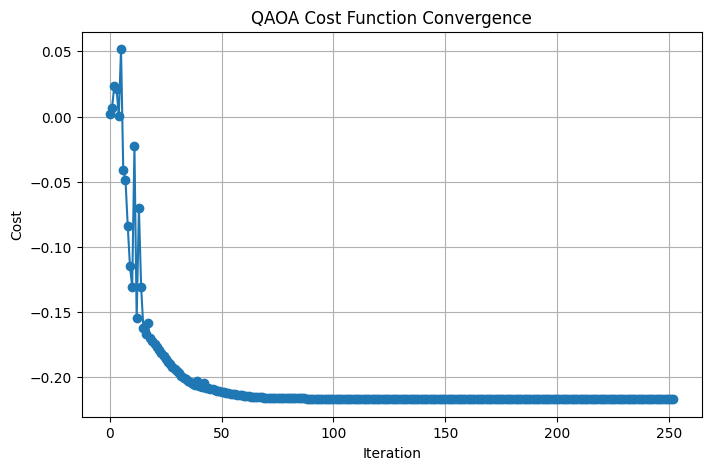

Optimal Parameters: [ 0.65403822 -4.72494284]


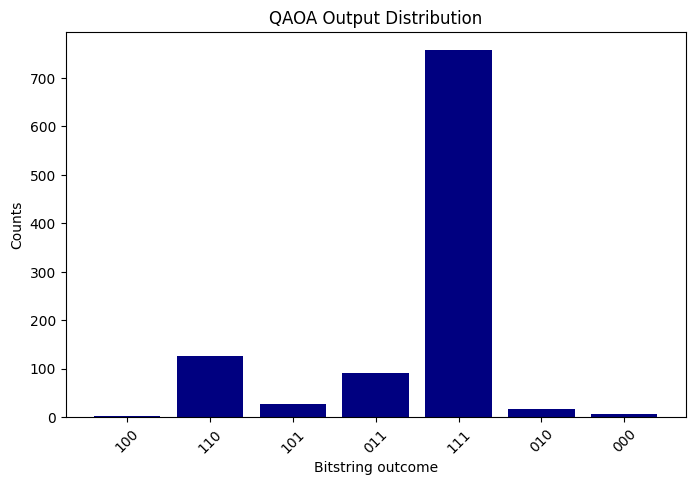

In [2]:
# Quantum Portfolio Optimization with Visualization
#-------------------------------------------------------------------------
# Quantum NLP with Visualization
# Chapter 8 in the QUANTUM COMPUTING AND QUANTUM MACHINE LEARNING BOOK
#-------------------------------------------------------------------------
# Version 1.0
# (c) 2025 Jesse Van Griensven, Roydon Fraser, and Jose Rosas
# License:  MIT - Citation of this work required
#-------------------------------------------------------------------------
# Qiskit changes frequently. 
# We recommend using the latest version from the book code repository at:
# https://github.com/pedroer/quantum-computing-for-engineers/blob/main/requirements.txt

import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit, transpile, assemble, execute
from qiskit.circuit import Parameter
from qiskit.opflow import I, Z, X, PauliSumOp, StateFn, CircuitSampler
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
import warnings
warnings.filterwarnings('ignore')
#-------------------------------------------------------------------------

def get_cost_hamiltonian(Q):
    """
    Given a covariance matrix Q, build the cost Hamiltonian
    as a PauliSumOp for QAOA.
    """
    num_qubits = len(Q)
    terms = []
    
    for i in range(num_qubits):
        for j in range(num_qubits):
            if Q[i, j] == 0:
                continue
            
            label = ["I"] * num_qubits
            label[i] = "Z"
            if j != i:
                label[j] = "Z"
            
            pauli_string = "".join(label)   # e.g. 'ZIZ' for 3 qubits
            coefficient = Q[i, j]
            
            # (pauli_string, coefficient)
            terms.append((pauli_string, coefficient))
    
    return PauliSumOp.from_list(terms)

#-------------------------------------------------------------------------
# Create QAOA ansatz with visualization
def qaoa_ansatz(beta, gamma, num_qubits):
    qc = QuantumCircuit(num_qubits)
    
    # Initialize in superposition
    for i in range(num_qubits):
        qc.h(i)
    
    # Apply phase-separation unitary
    for i in range(num_qubits):
        qc.rz(2 * gamma * Q[i, i], i)
        for j in range(i + 1, num_qubits):
            qc.cx(i, j)
            qc.rz(2 * gamma * Q[i, j], j)
            qc.cx(i, j)
    
    # Apply mixing Hamiltonian
    for i in range(num_qubits):
        qc.rx(2 * beta, i)
    
    return qc

#-------------------------------------------------------------------------
# Define cost function
def cost_function(params):
    beta, gamma = params
    qc = qaoa_ansatz(beta, gamma, 3)

    # Uncomment to visualize the QAOA circuit at each iteration
    # print("\nQAOA Circuit:")
    # display(qc.draw(output='mpl'))
    
    # Calculate expectation value
    measurable_expression = StateFn(H, is_measurement=True) @ StateFn(qc)
    sampler = CircuitSampler(QuantumInstance(Aer.get_backend('statevector_simulator')))
    return np.real(sampler.convert(measurable_expression).eval())
#-------------------------------------------------------------------------

def track_cost(params):
    val = cost_function(params)
    cost_values.append(val)
    params_list.append(params)
    return val
#-------------------------------------------------------------------------

# Define the covariance matrix (Q)
Q = np.array([
    [0.1, 0.02, 0.04],
    [0.02, 0.15, 0.01],
    [0.04, 0.01, 0.12]
])

# Build the Hamiltonian
H = get_cost_hamiltonian(Q)

# Set up optimizer
initial_params = [0.1, 0.1]
optimizer = COBYLA()

# Track cost for visualization
cost_values = []
params_list = []

# Optimization
result = optimizer.minimize(fun=track_cost, x0=initial_params)

# Plot convergence
plt.figure(figsize=(8, 5))
plt.plot(range(len(cost_values)), cost_values, marker='o')
plt.title("QAOA Cost Function Convergence")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

# Print final result
print(f"Optimal Parameters: {result.x}")

# Run optimized circuit on qasm simulator for measurement distribution
simulator    = Aer.get_backend('qasm_simulator')
qc_optimized = qaoa_ansatz(result.x[0], result.x[1], 3)
qc_optimized.measure_all()

job    = execute(qc_optimized, backend=simulator, shots=1024)
counts = job.result().get_counts()

# Plot measurement distribution
plt.figure(figsize=(8, 5))
plt.bar(counts.keys(), counts.values(), color='navy')
plt.xlabel("Bitstring outcome")
plt.ylabel("Counts")
plt.title("QAOA Output Distribution")
plt.xticks(rotation=45)
plt.show()
